## Part 1. Imports and Dependencies

In [1]:
import pandas as pd
import hvplot.pandas
import sys
sys.path.append('../../')

## Part 2. Loading and Cleaning the Per-Timestep Tensor

Option 1. Run the simulation.

In [2]:
# import os
# os.chdir('../../')
# from subspace_model.experiments.experiment import psuu
# sim_df = psuu(SIMULATION_DAYS=3*365, TIMESTEP_IN_DAYS=7, SAMPLES=1, N_SWEEP_SAMPLES=160,   SWEEPS_PER_PROCESS=10, PROCESSES=8, PARALLELIZE=True, USE_JOBLIB=True)

Option 2. Load the latest psuu simulation data.

In [3]:
from glob import glob
latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]
sim_df = pd.read_pickle(latest, compression='gzip')


2024-04-15 12:28:28 - subspace-digital-twin - INFO
------------subspace-digital-twin------------


Unpacking the subsidy component parameters and adding them to the dataset.

In [4]:
i = 0
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)

i = 1
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)



## Part 3. Aggregating by Trajectory and Transforming into KPIs.

Get the governance surface dimension keys.

In [5]:
from subspace_model.params import GOVERNANCE_SURFACE
GOVERNANCE_SURFACE.keys()

dict_keys(['reference_subsidy_components', 'reward_proposer_share', 'weight_to_fee'])

Include the unpacked reference subsidy component parameters.

In [6]:
# We need to add the unpacked component parameter names and remove 'reference_subsidy_component'
governance_surface_params: set = (set(GOVERNANCE_SURFACE.keys()) | {c for c in sim_df.columns if 'component' in c}) - {'reference_subsidy_components'}
governance_surface_params

{'component_1_initial_period_duration',
 'component_1_initial_period_start',
 'component_1_max_cumulative_subsidy',
 'component_1_max_reference_subsidy',
 'component_2_initial_period_duration',
 'component_2_initial_period_start',
 'component_2_max_cumulative_subsidy',
 'component_2_max_reference_subsidy',
 'reward_proposer_share',
 'weight_to_fee'}

Get the trajectory id columns that will be the columns of our feature sets. Data is grouped by these keys when applying KPI aggregation functions.

In [7]:
trajectory_id_columns = ['simulation', 'subset', 'run'] + list(governance_surface_params)
trajectory_id_columns

['simulation',
 'subset',
 'run',
 'component_2_initial_period_duration',
 'reward_proposer_share',
 'weight_to_fee',
 'component_1_max_reference_subsidy',
 'component_2_initial_period_start',
 'component_2_max_cumulative_subsidy',
 'component_2_max_reference_subsidy',
 'component_1_initial_period_duration',
 'component_1_initial_period_start',
 'component_1_max_cumulative_subsidy']

Import the defined KPI aggregation functions

In [8]:
from subspace_model.psuu.kpis import KPI_functions
list(KPI_functions.keys())

['mean_relative_community_owned_supply',
 'mean_farmer_subsidy_factor',
 'mean_proposing_rewards_per_newly_pledged_space',
 'mean_proposer_reward_minus_voter_reward',
 'cumm_rewards_before_1yr',
 'abs_sum_storage_fees_per_sum_compute_fees',
 'cumm_rewards']

Generating the KPIs and Labels datasets.

In [9]:
kpi_dfs = []
label_dfs = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_s = sim_df.groupby(trajectory_id_columns).apply(kpi_f, include_groups=False)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)

    label_s = kpi_s.map(lambda x: threshold_f(x, kpi_s.values))
    label_s.name = kpi
    label_dfs.append(label_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)
all_labels_df = pd.concat(label_dfs, axis=1)

KPI Results per Trajectory

In [10]:
all_kpi_df

mean_relative_community_owned_supply  \
simulation subset run component_2_initial_period_duration reward_proposer_share weight_to_fee component_1_max_reference_subsidy component_2_initial_period_start component_2_max_cumulative_subsidy component_2_max_reference_subsidy component_1_initial_period_duration component_1_initial_period_start component_1_max_cumulative_subsidy                                         
0          0      1   10512000.0                          0.100000              1.000000e-15  0.1                               30                               7                                  0.5                               0                                   0                                7                                                               1.193369   
                  2   10512000.0                          0.100000              1.000000e-15  0.1                               30                               7                                  0.5                               0                                   0                                7                                                               1.193369   
           1      1   21024000.0                          0.100000              1.000000e-15  0.3                               14                               7                                  0.1                               0                                   0                                1                                                               1.192836   
                  2   21024000.0                          0.100000              1.000000e-15  0.3                               14                               7                                  0.1                               0                                   0                                1                                                               1.192836   
           2      1   2628000.0                           0.100000              1.000000e-15  0.5                               14                               7                                  0.5                               0                                   0                                1                                                               1.192307   
...                                                                                                                                                                                                                                                                                                                                                                             ...   
           45     2   10512000.0                          0.100000              1.000000e-18  0.3                               0                                1                                  0.1                               0                                   0                                4                                                               1.192836   
           46     1   21024000.0                          0.333333              1.000000e-16  0.1                               14                               7                                  0.3                               0                                   14                               7                                                               1.193369   
                  2   21024000.0                          0.333333              1.000000e-16  0.1                               14                               7                                  0.3                               0                                   14                               7                                                               1.193369   
           47     1   10512000.0                          0.100000              1.000000e-18  0.1                               30                               1                                  0.5           

Utility per trajectory

In [11]:
pd.set_option('future.no_silent_downcasting', True)

utility_df = all_labels_df.replace({True:1,False:0,None:0})
utility_df

mean_relative_community_owned_supply  \
simulation subset run component_2_initial_period_duration reward_proposer_share weight_to_fee component_1_max_reference_subsidy component_2_initial_period_start component_2_max_cumulative_subsidy component_2_max_reference_subsidy component_1_initial_period_duration component_1_initial_period_start component_1_max_cumulative_subsidy                                        
0          0      1   10512000.0                          0.100000              1.000000e-15  0.1                               30                               7                                  0.5                               0                                   0                                7                                                                     1   
                  2   10512000.0                          0.100000              1.000000e-15  0.1                               30                               7                                  0.5                               0                                   0                                7                                                                     1   
           1      1   21024000.0                          0.100000              1.000000e-15  0.3                               14                               7                                  0.1                               0                                   0                                1                                                                     0   
                  2   21024000.0                          0.100000              1.000000e-15  0.3                               14                               7                                  0.1                               0                                   0                                1                                                                     0   
           2      1   2628000.0                           0.100000              1.000000e-15  0.5                               14                               7                                  0.5                               0                                   0                                1                                                                     0   
...                                                                                                                                                                                                                                                                                                                                                                            ...   
           45     2   10512000.0                          0.100000              1.000000e-18  0.3                               0                                1                                  0.1                               0                                   0                                4                                                                     0   
           46     1   21024000.0                          0.333333              1.000000e-16  0.1                               14                               7                                  0.3                               0                                   14                               7                                                                     1   
                  2   21024000.0                          0.333333              1.000000e-16  0.1                               14                               7                                  0.3                               0                                   14                               7                                                                     1   
           47     1   10512000.0                          0.100000              1.000000e-18  0.1                               30                               1                                  0.5                     

In [12]:
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

Exploring max utility parameter value occurences.

In [13]:
# Get value counts of each parameter in max utility sets.
utility_sum_df = utility_df.sum(axis=1).to_frame().sort_values(0, ascending=False)
utility_sum_max_df = utility_sum_df[utility_sum_df[0] == utility_sum_df[0].max()]
parameter_value_occurrences_in_max_utility = [(g,utility_sum_max_df.reset_index()[g].value_counts().to_dict()) for g in governance_surface_params]

# Process each KPI and its corresponding dictionary
rows = []
for kpi, param_dict in parameter_value_occurrences_in_max_utility:
    for parameter_value, occurrences_in_max_utility in param_dict.items():
        row = {
            'KPI': kpi,
            'parameter_value': parameter_value,
            'occurrences_in_max_utility': occurrences_in_max_utility
        }
        rows.append(row)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(rows)

In [19]:
df = df.sort_values('occurrences_in_max_utility', ascending=False)
df

,KPI,parameter_value,occurrences_in_max_utility
21,component_1_initial_period_duration,0.000000e+00,46
10,component_1_max_reference_subsidy,1.000000e-01,44
4,reward_proposer_share,1.000000e-01,24
5,reward_proposer_share,3.333333e-01,22
22,component_1_initial_period_start,3.000000e+01,22
18,component_2_max_reference_subsidy,5.000000e-01,20
25,component_1_max_cumulative_subsidy,7.000000e+00,18
19,component_2_max_reference_subsidy,1.000000e-01,18
15,component_2_max_cumulative_subsidy,1.000000e+00,18
0,component_2_initial_period_duration,2.102400e+07,16


In [20]:
df.groupby('KPI').first()

,parameter_value,occurrences_in_max_utility
KPI,,
component_1_initial_period_duration,0.000000e+00,46
component_1_initial_period_start,3.000000e+01,22
component_1_max_cumulative_subsidy,7.000000e+00,18
component_1_max_reference_subsidy,1.000000e-01,44
component_2_initial_period_duration,2.102400e+07,16
component_2_initial_period_start,3.000000e+01,16
component_2_max_cumulative_subsidy,1.000000e+00,18
component_2_max_reference_subsidy,5.000000e-01,20
reward_proposer_share,1.000000e-01,24


## Part 4. PSuU Analysis
Estimation of the Combined Parameters Causal Effect on KPI Thresholds & Utilities.

In [15]:
import matplotlib.pyplot as plt # type: ignore
from sklearn.tree import plot_tree # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
import seaborn as sns

def kpi_plot(label_df, kpi, drop_nan=True):
    df = label_df[kpi].reset_index()
    features = list(set(governance_surface_params) - {kpi})

    X = df.loc[:, features]
    y = df.loc[:, kpi].astype(bool)

    if drop_nan:
        inds = (y != None)
        X = X.loc[inds]
        y = y.loc[inds]

    model = DecisionTreeClassifier(max_depth=3)
    rf = RandomForestClassifier()
    model.fit(X, y)
    rf.fit(X, y)



    rf_df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )


    fig, axes = plt.subplots(nrows=2,
                                figsize=(36, 12),
                                dpi=200,
                                gridspec_kw={'height_ratios': [3, 1]})

    (ax_dt, ax_rf) = axes[0], axes[1]
    plot_tree(model,
                rounded=True,
                proportion=True,
                fontsize=11,
                feature_names=X.columns,
                class_names=['threshold not met', 'threshold met'],
                filled=True,
                ax=ax_dt)
    ax_dt.set_title(
        f'Decision tree for KPI {kpi}, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(data=rf_df,
                x=rf_df.features,
                y=rf_df.importance,
                ax=ax_rf,
                label='small')
    plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
    ax_rf.set_title(f'Feature importance')
    plt.show()

In [16]:
kpi = list(KPI_functions.keys())[0]
kpi

'mean_relative_community_owned_supply'

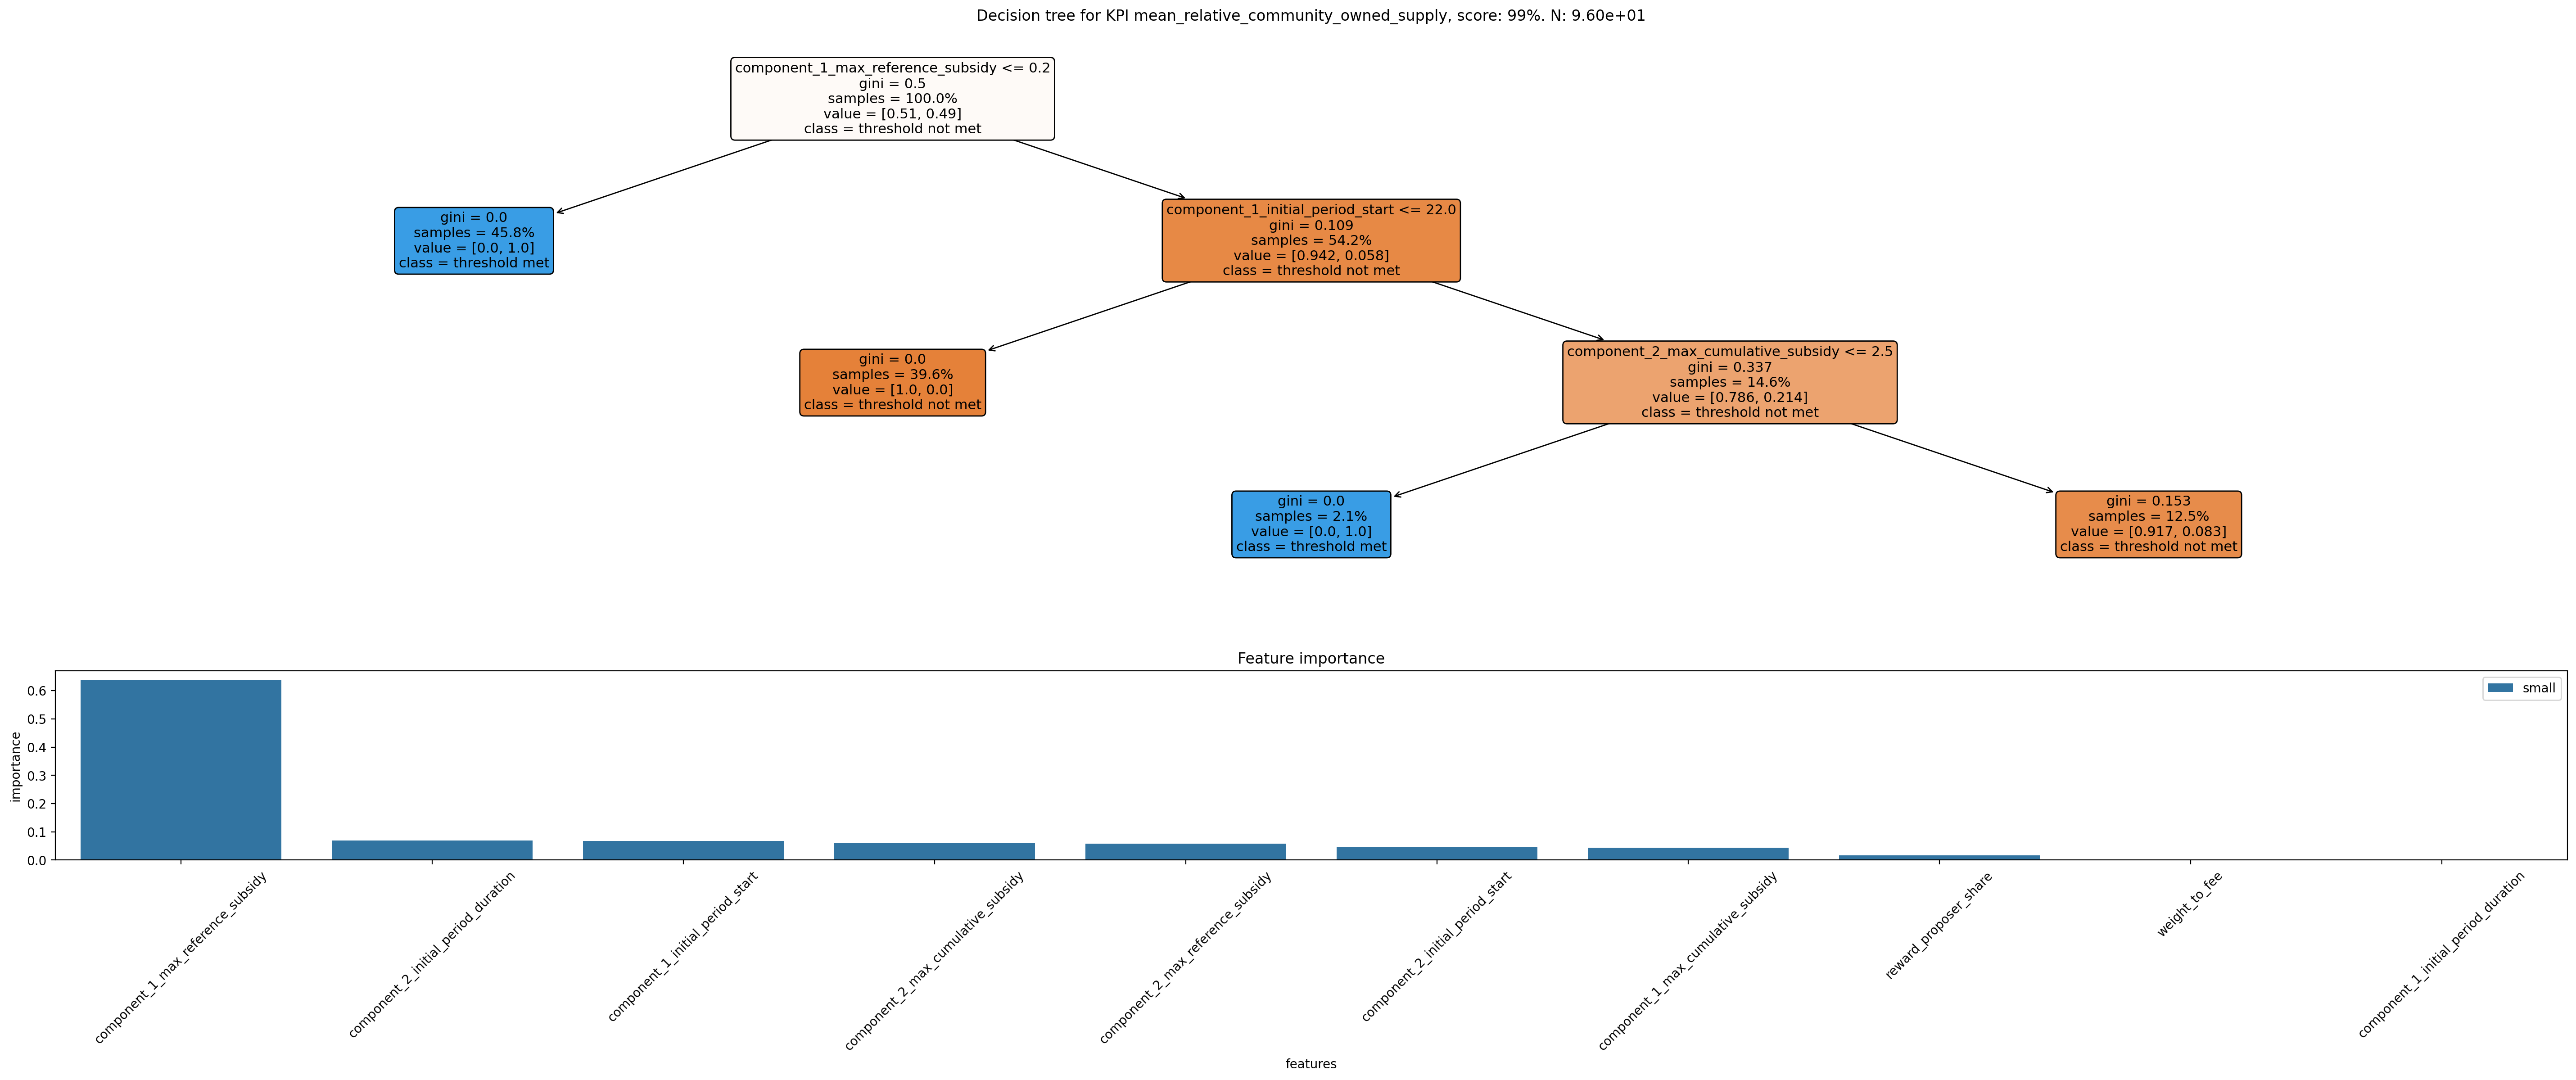

In [17]:
kpi_plot(all_labels_df, kpi)

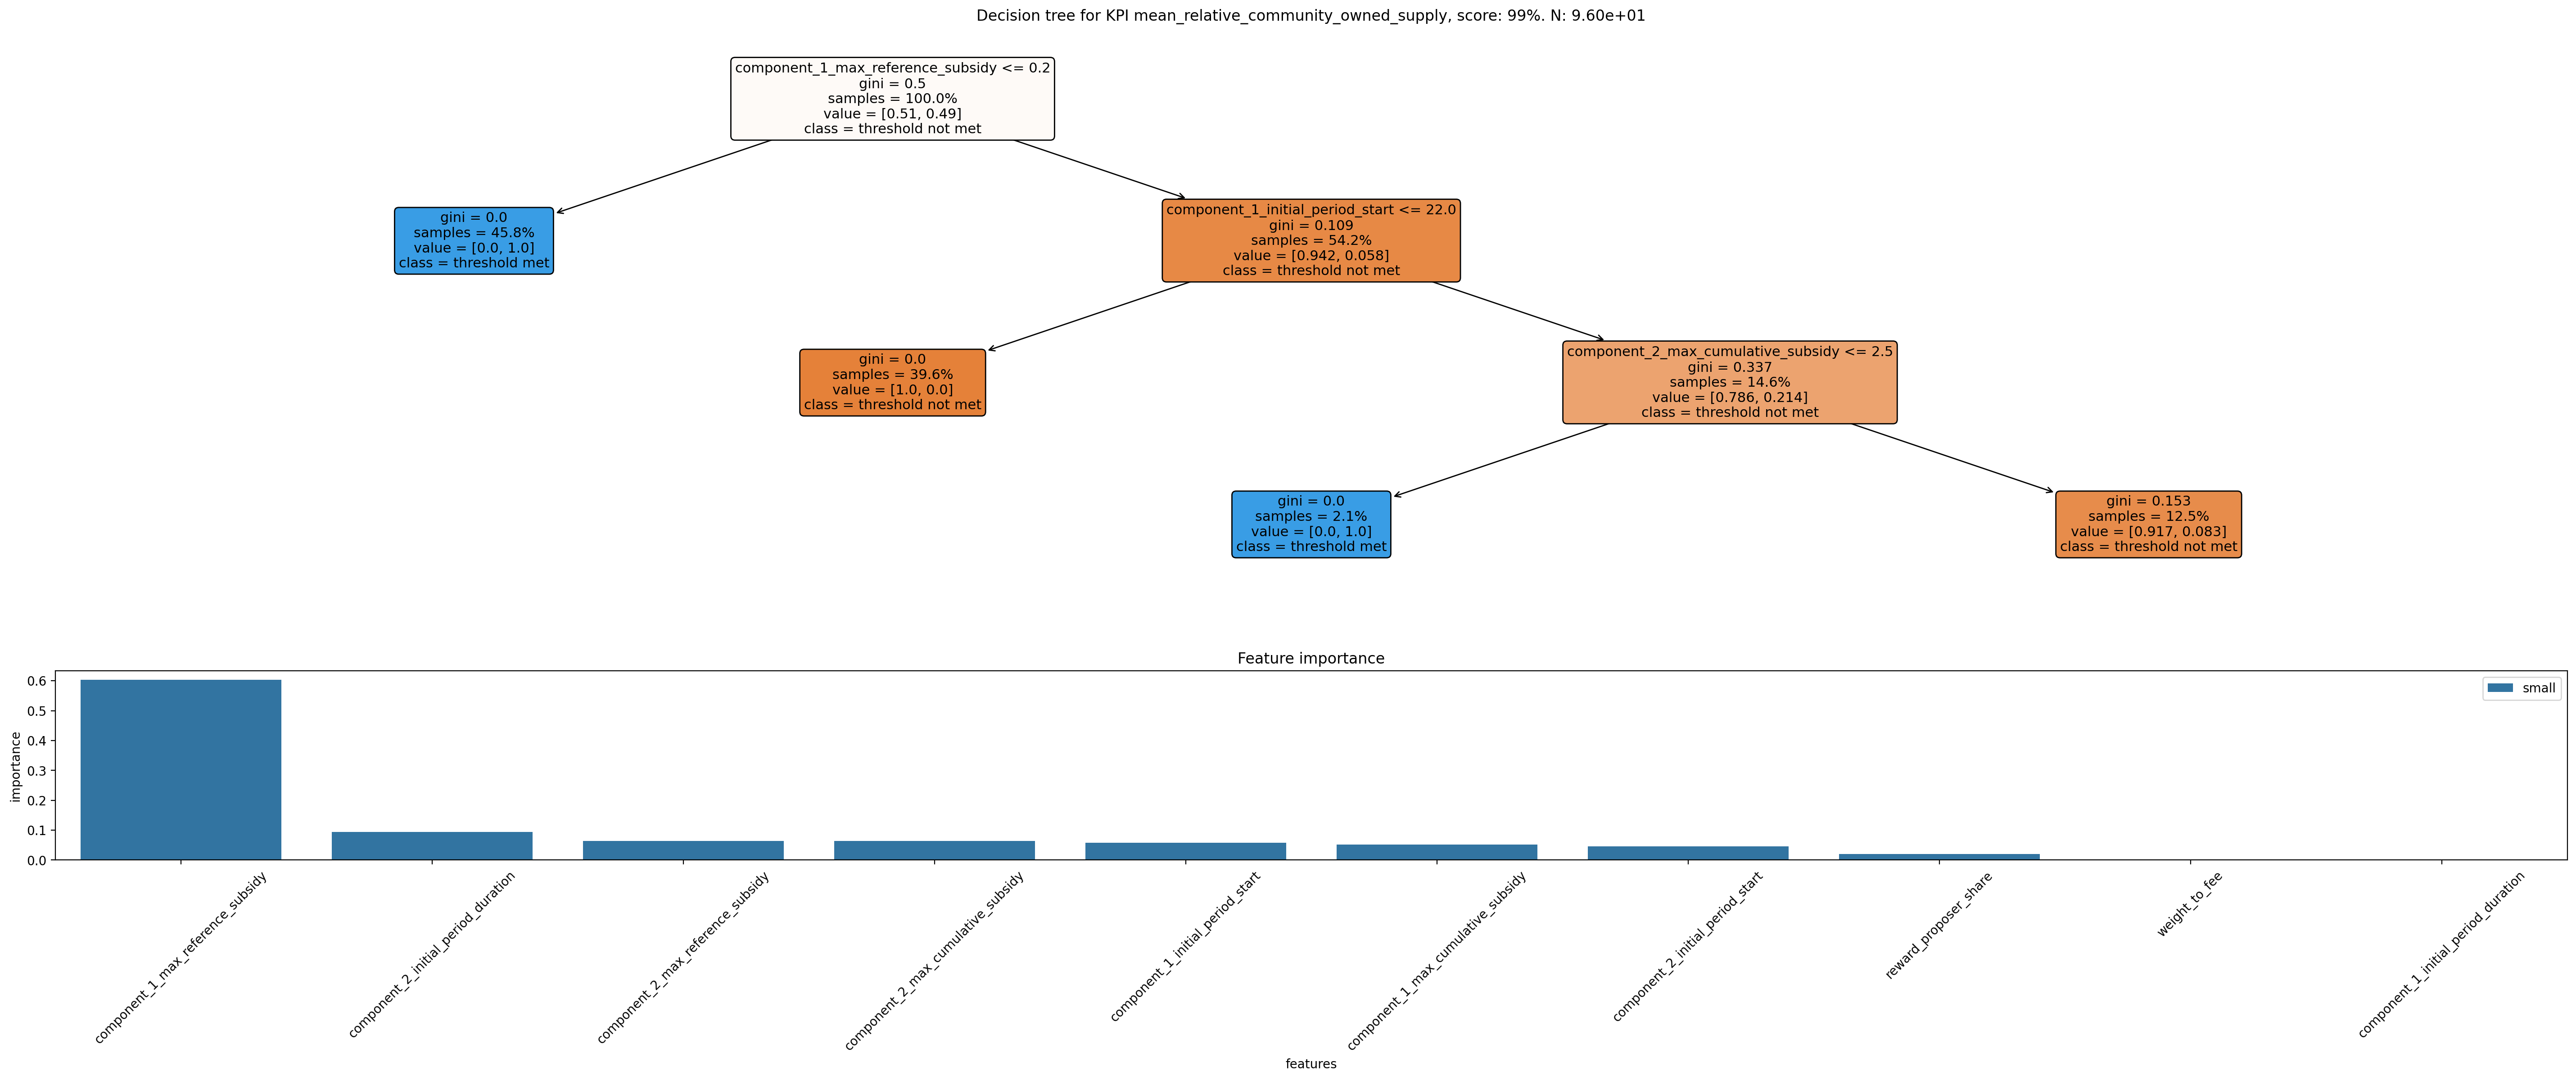

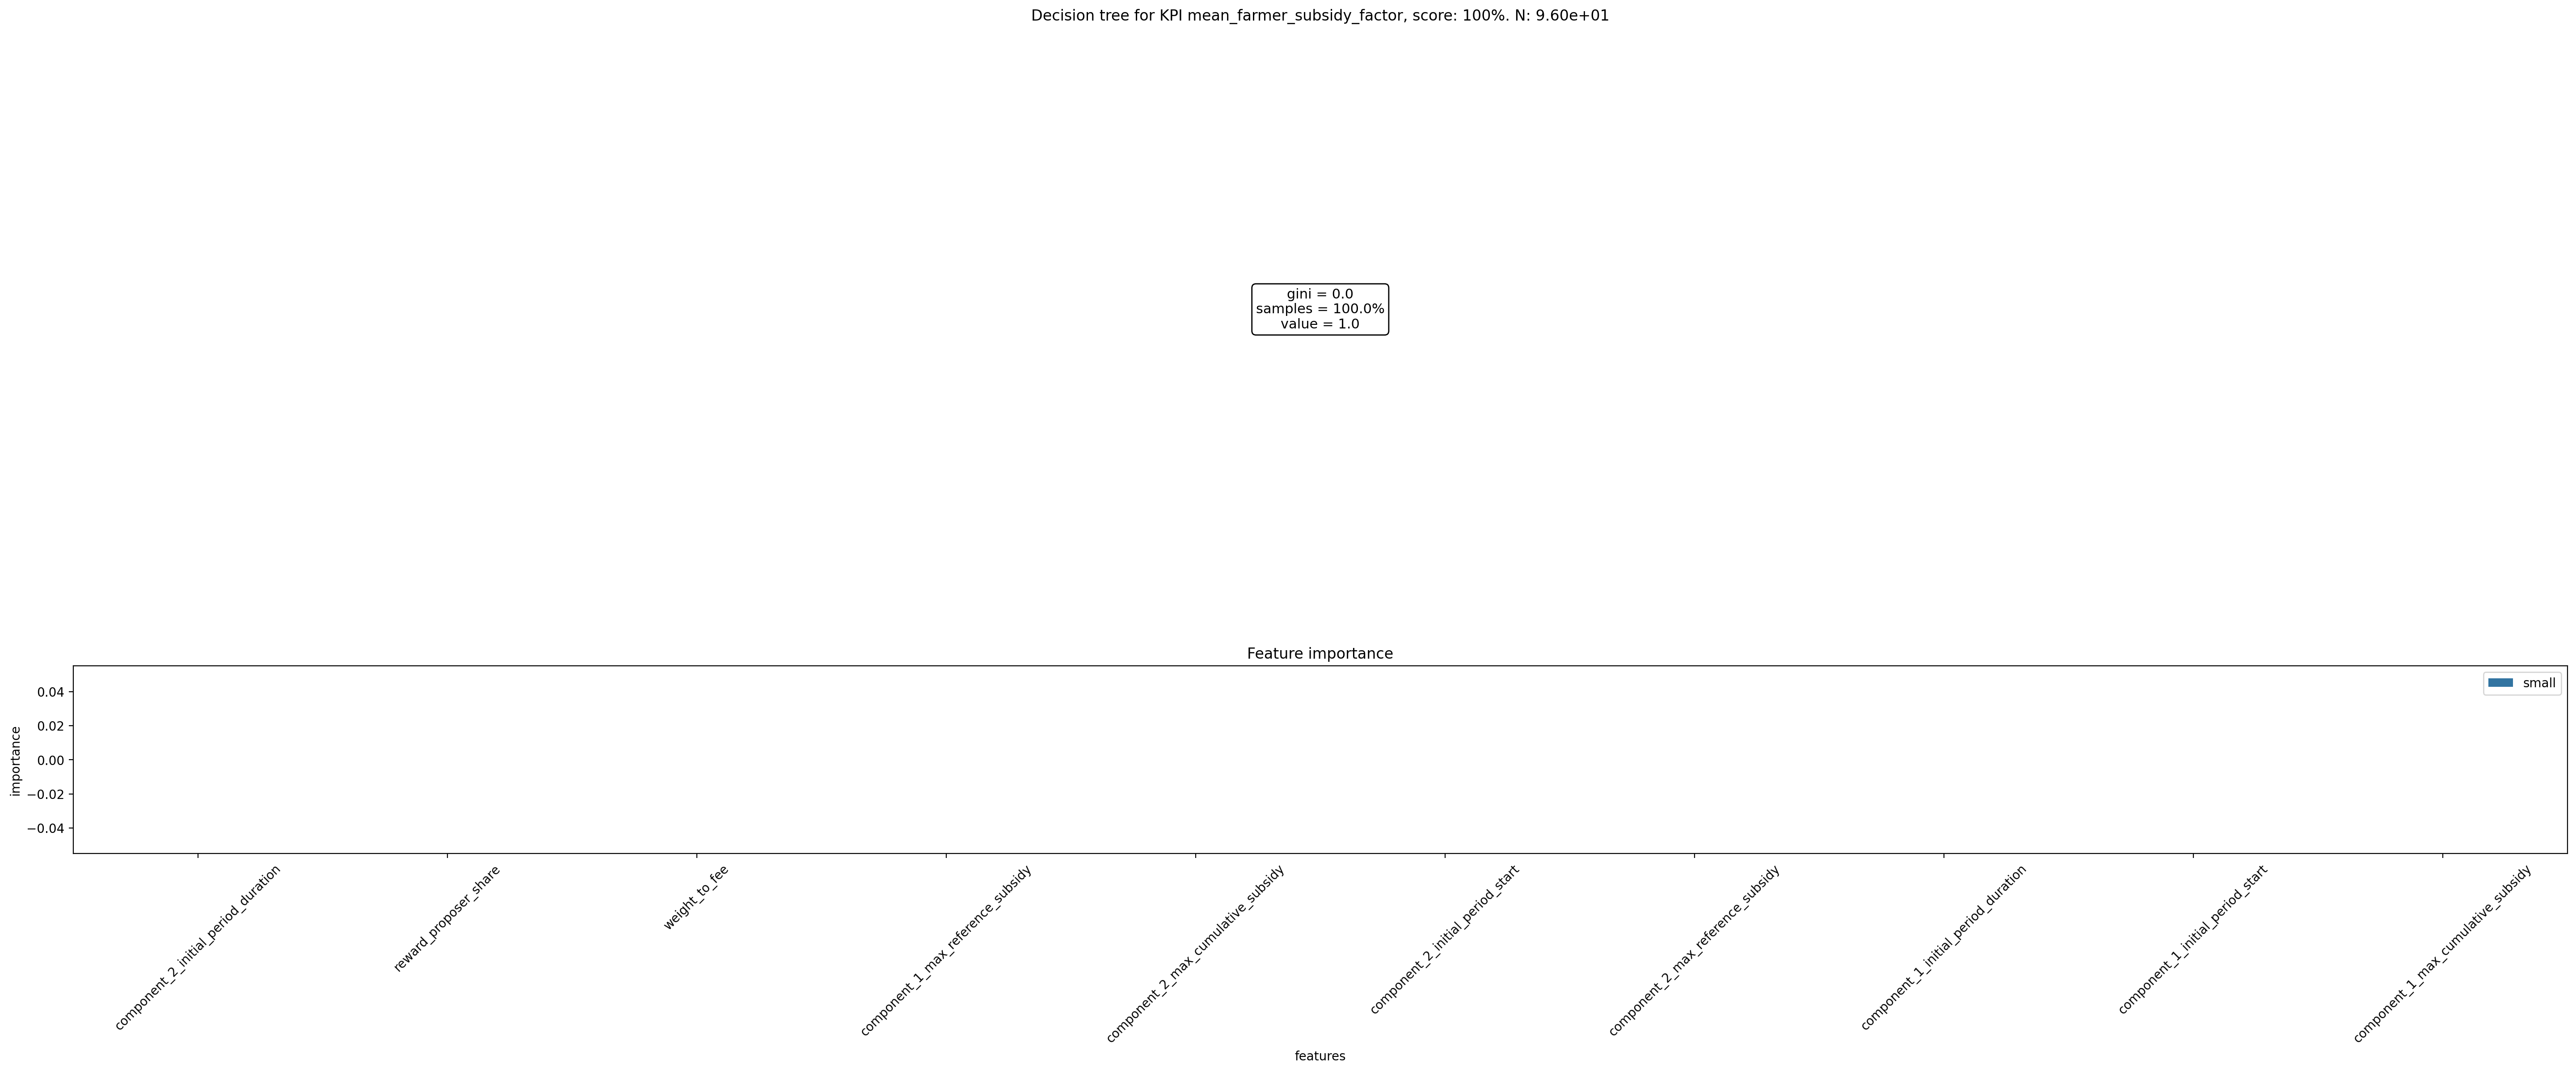

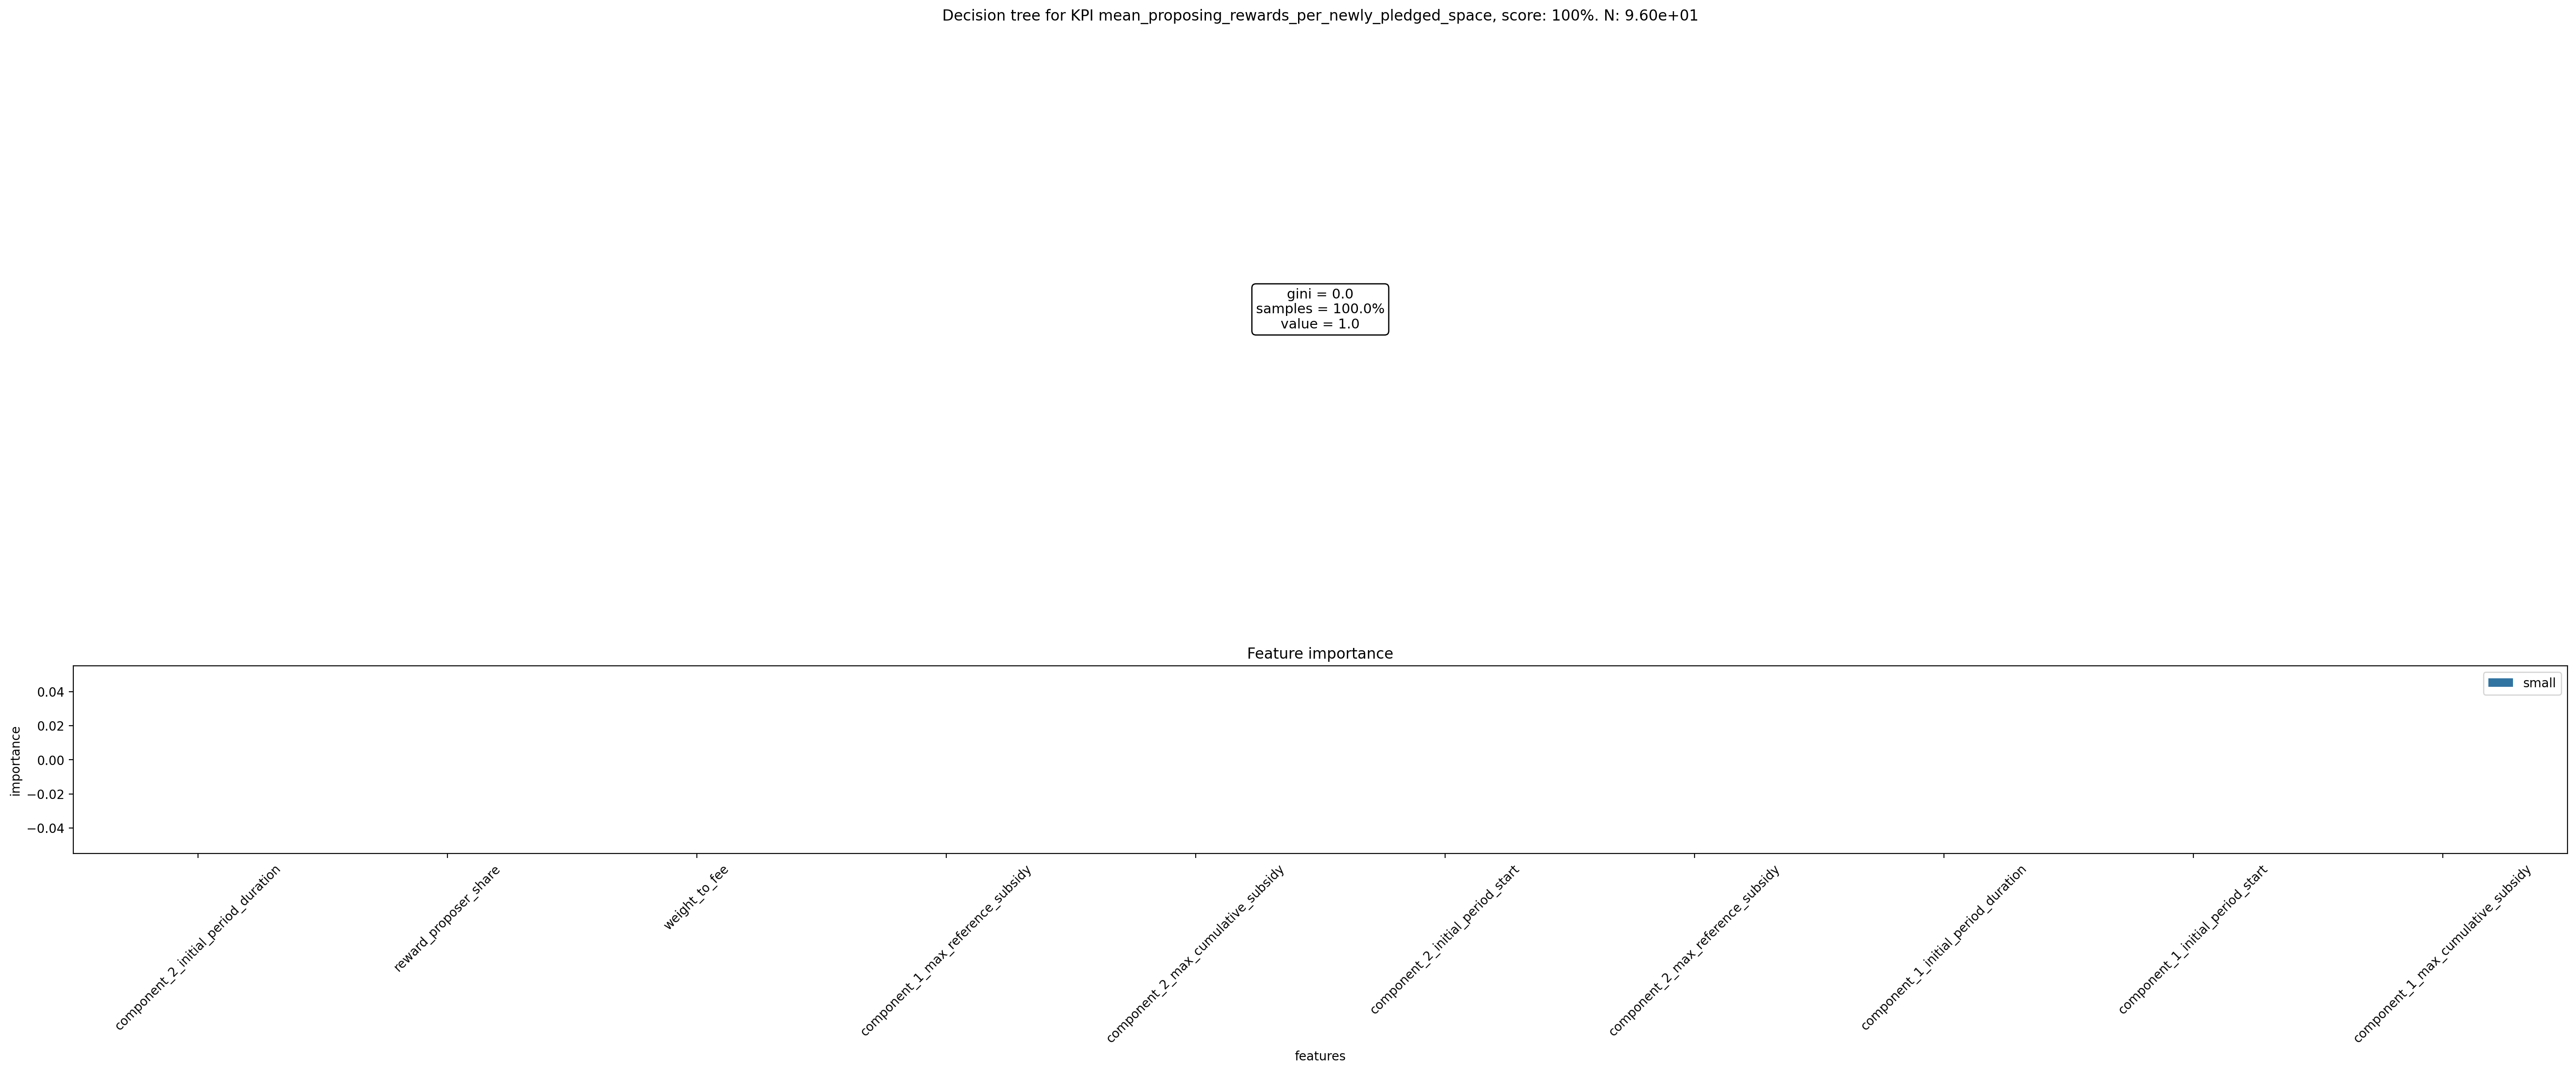

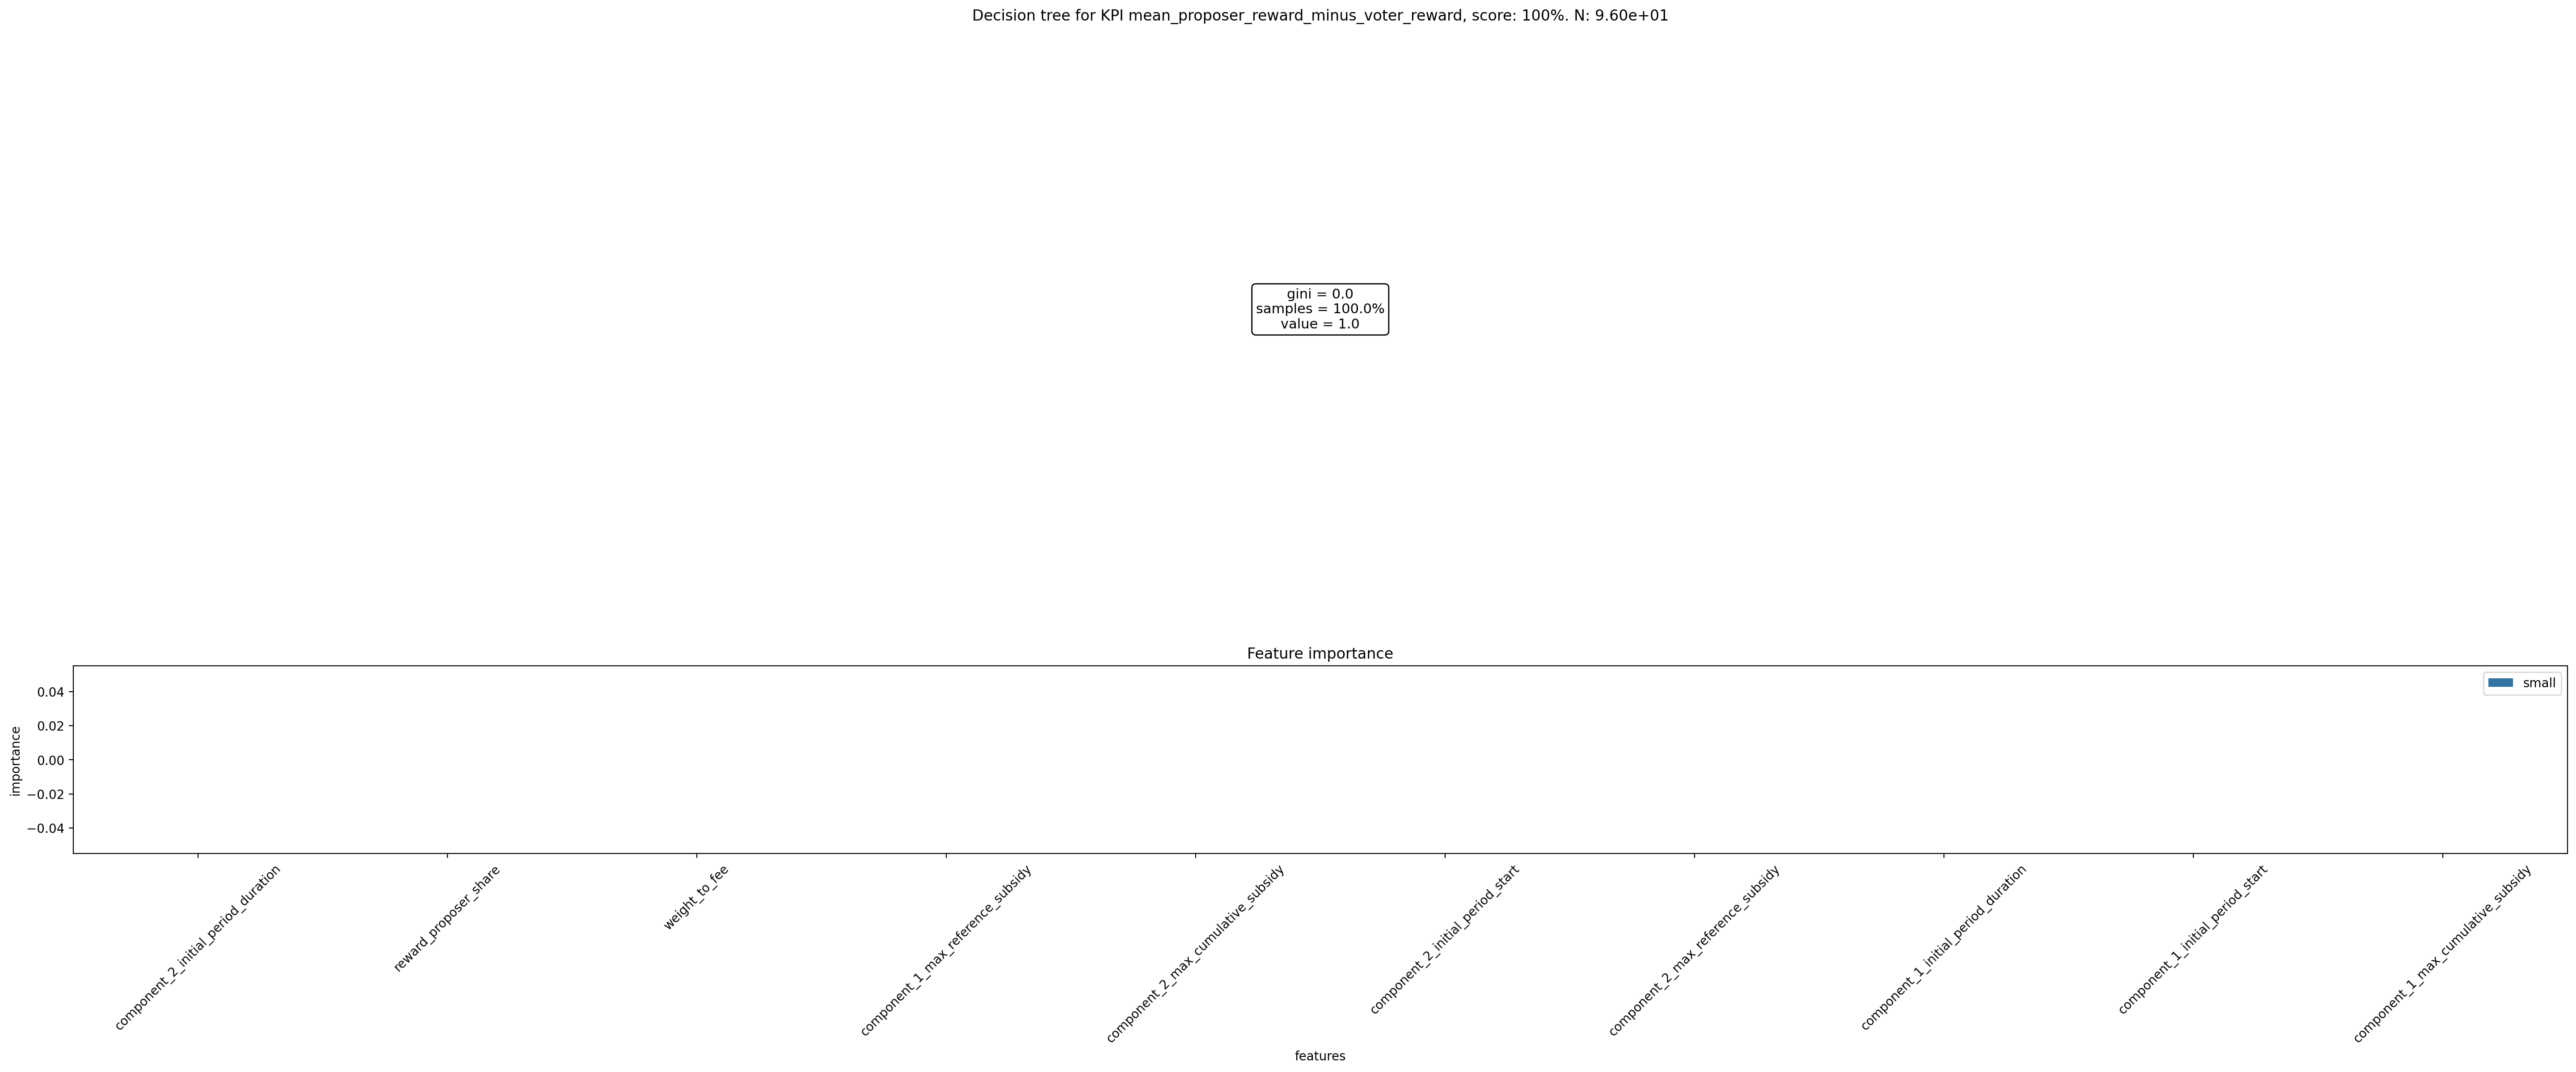

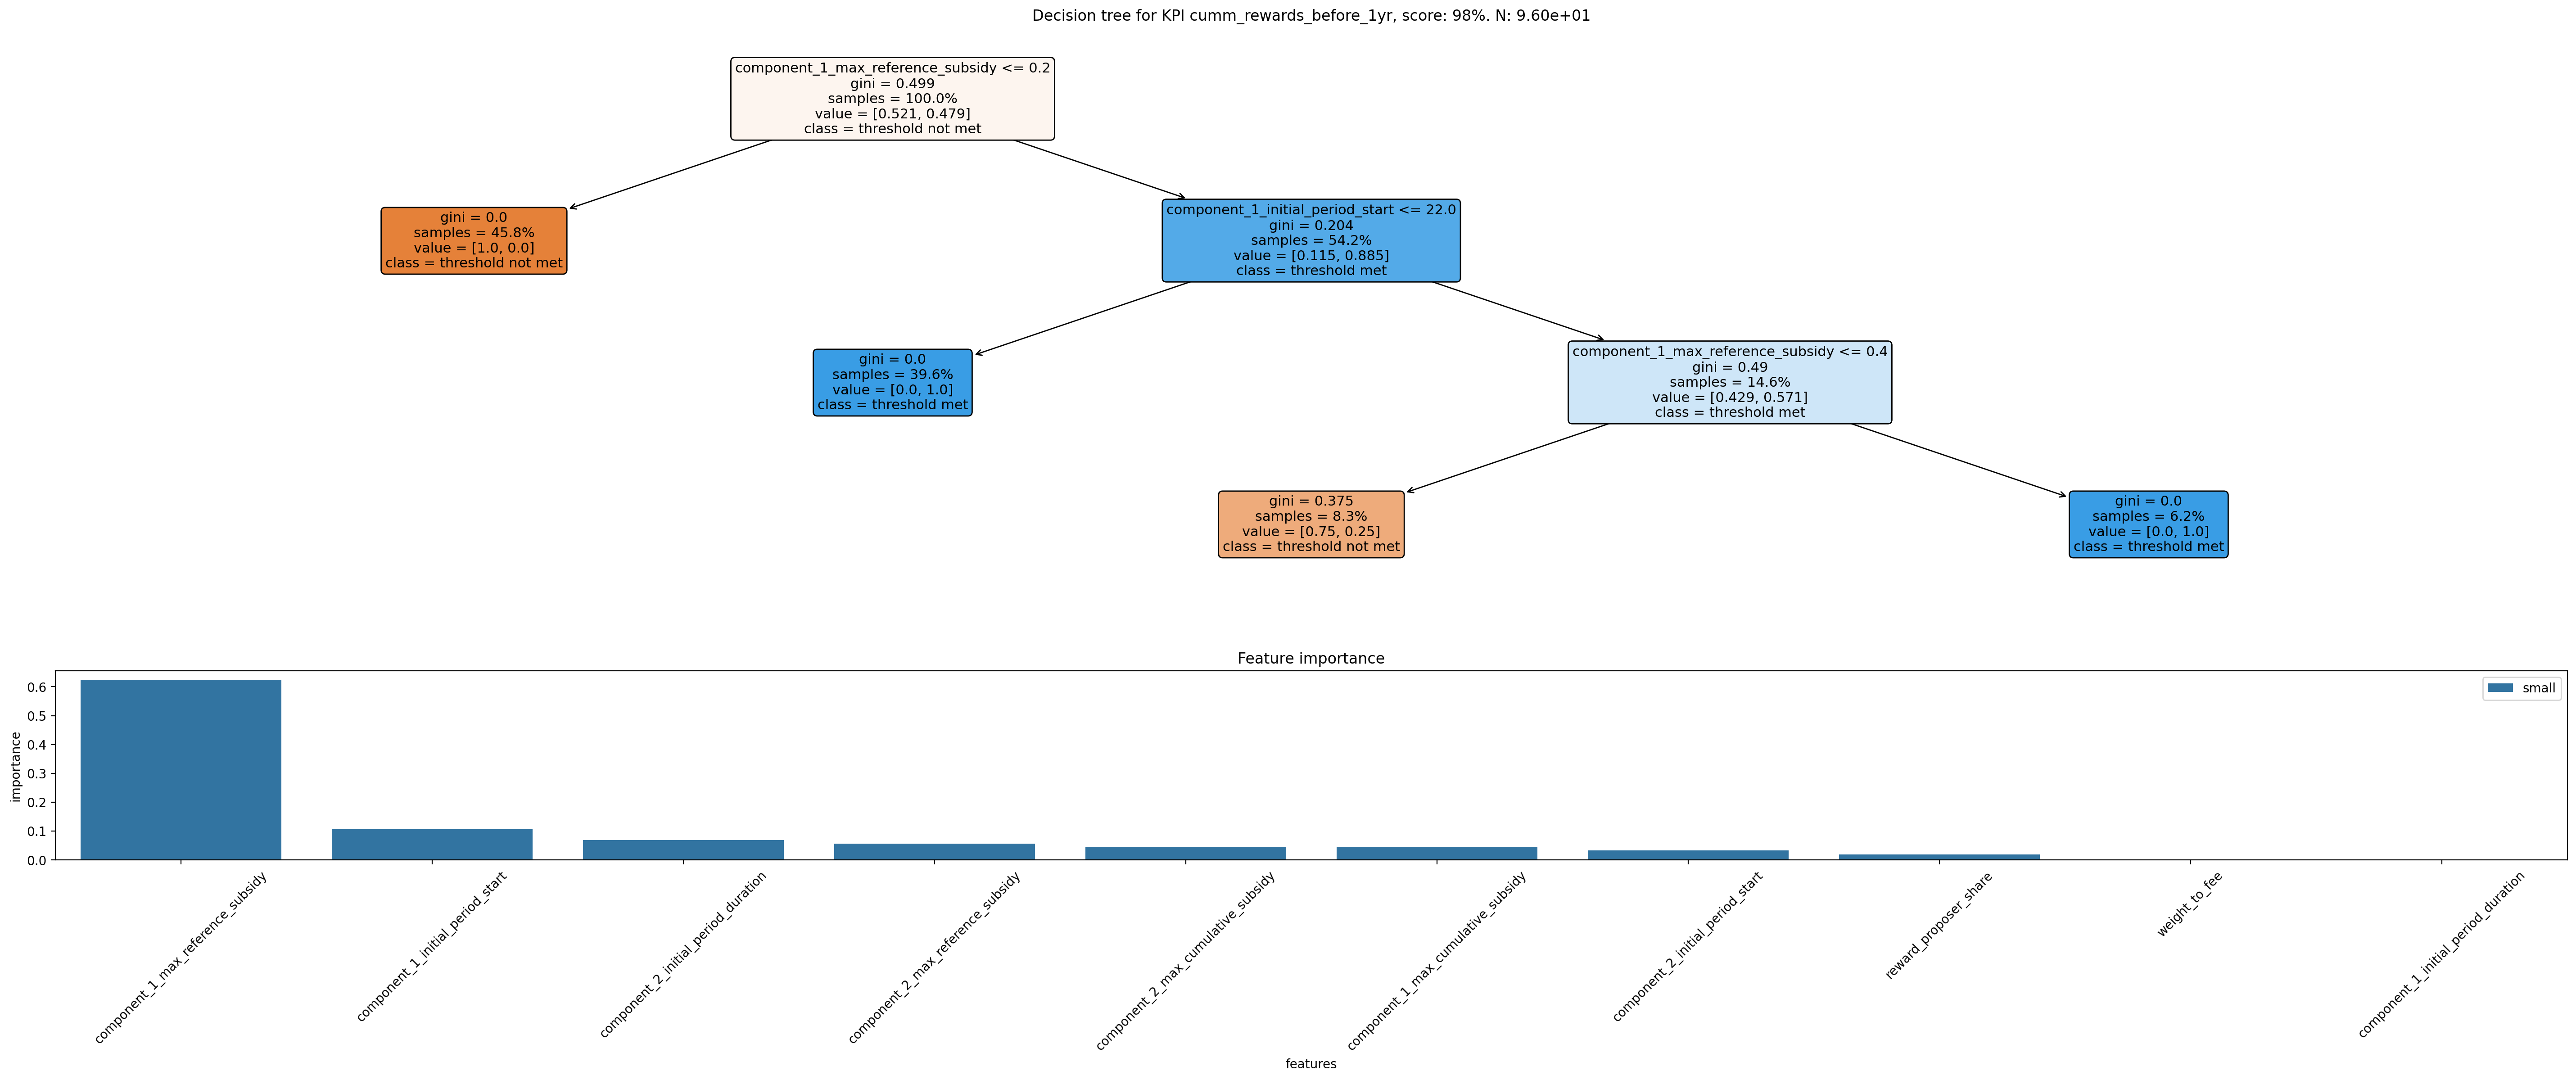

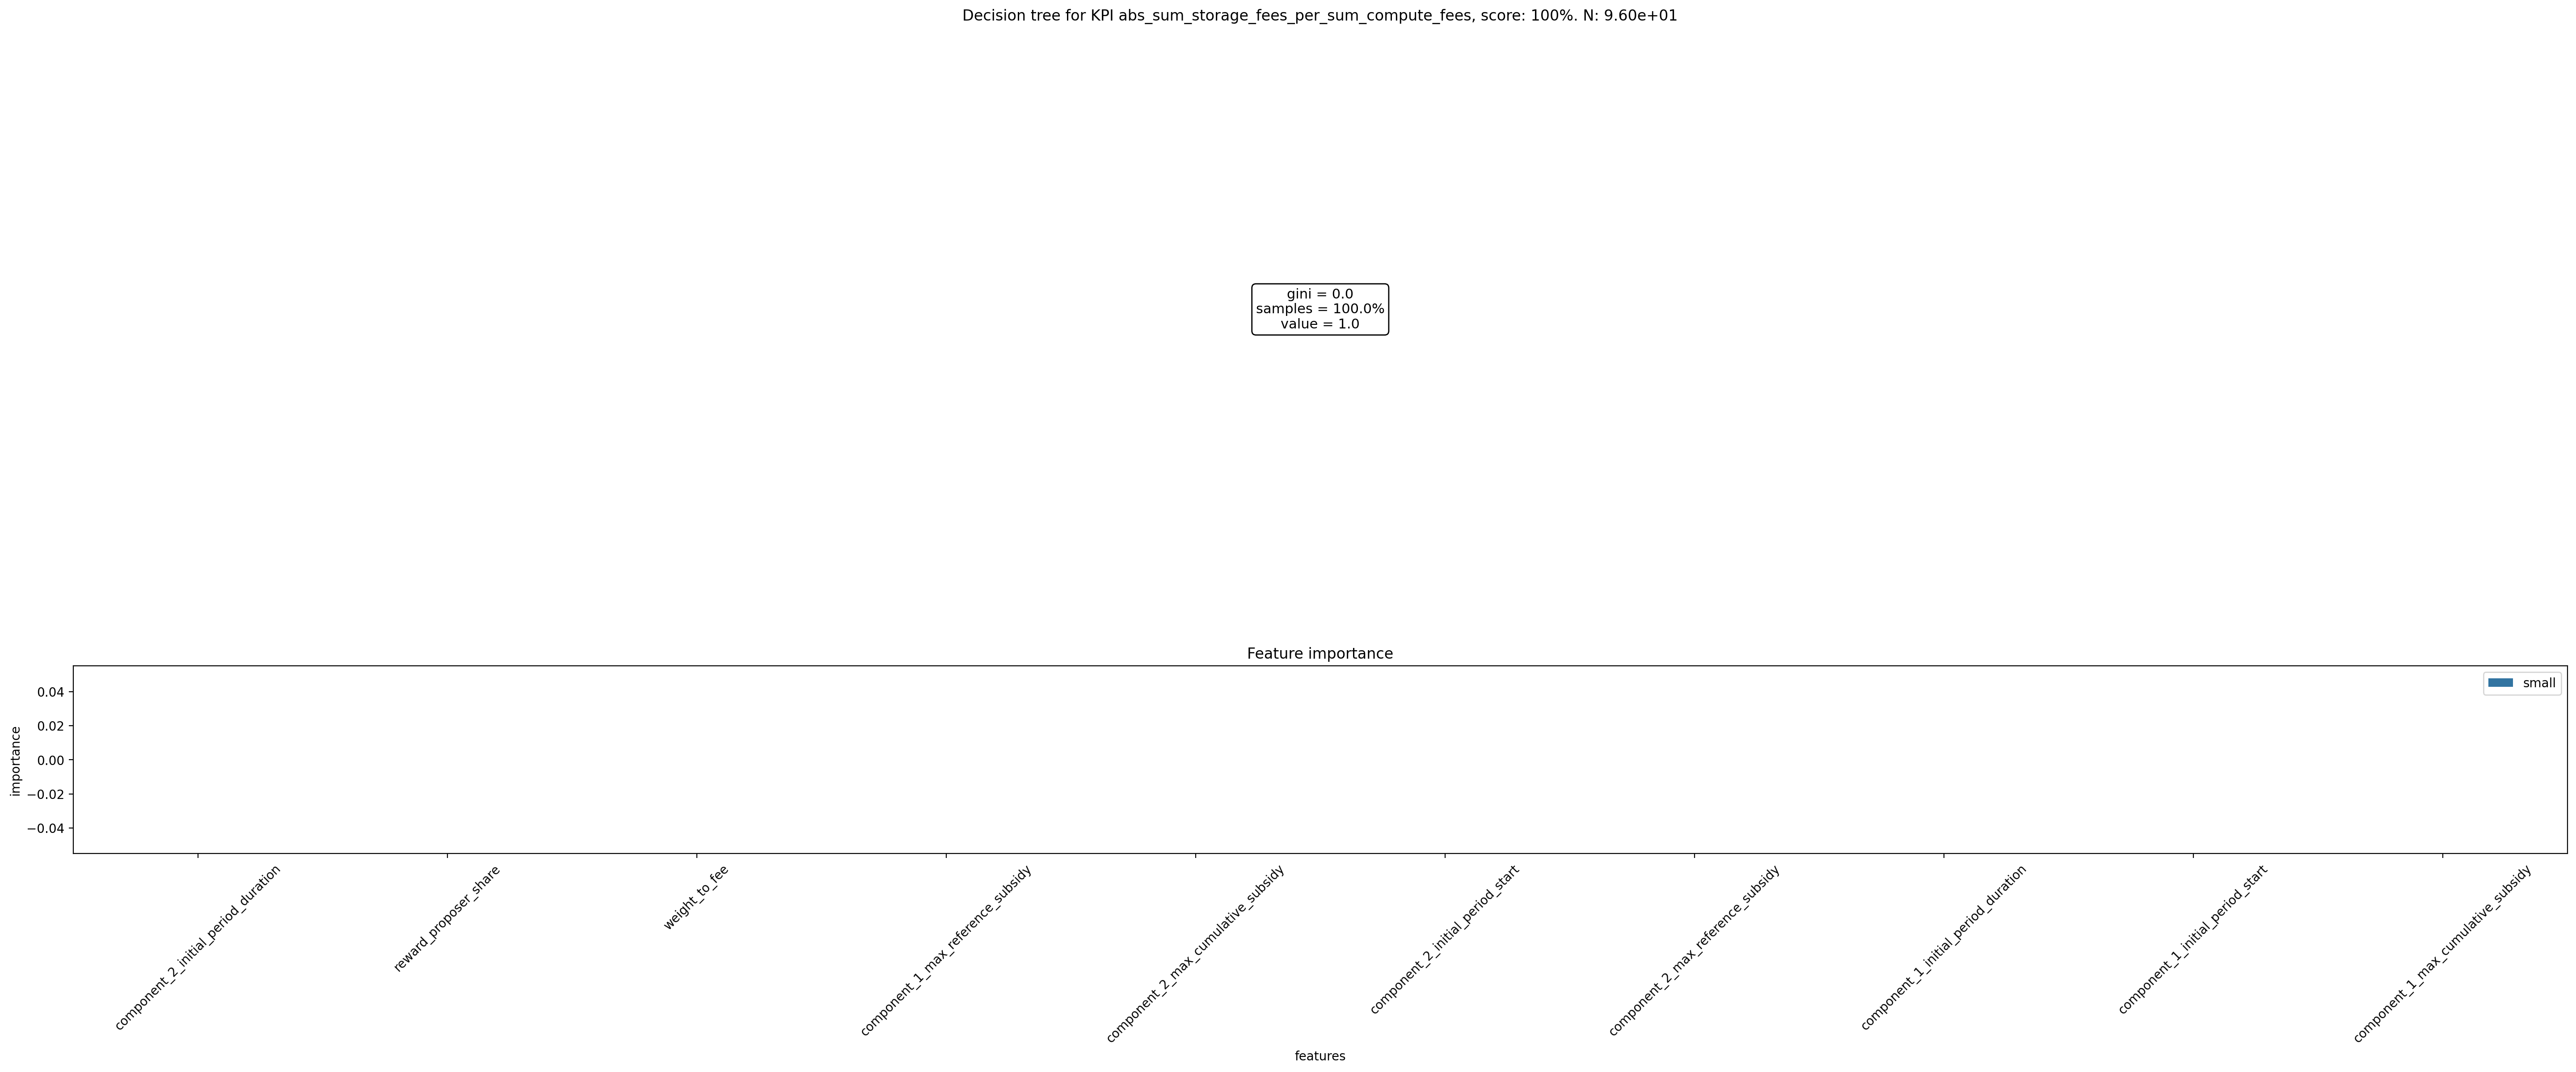

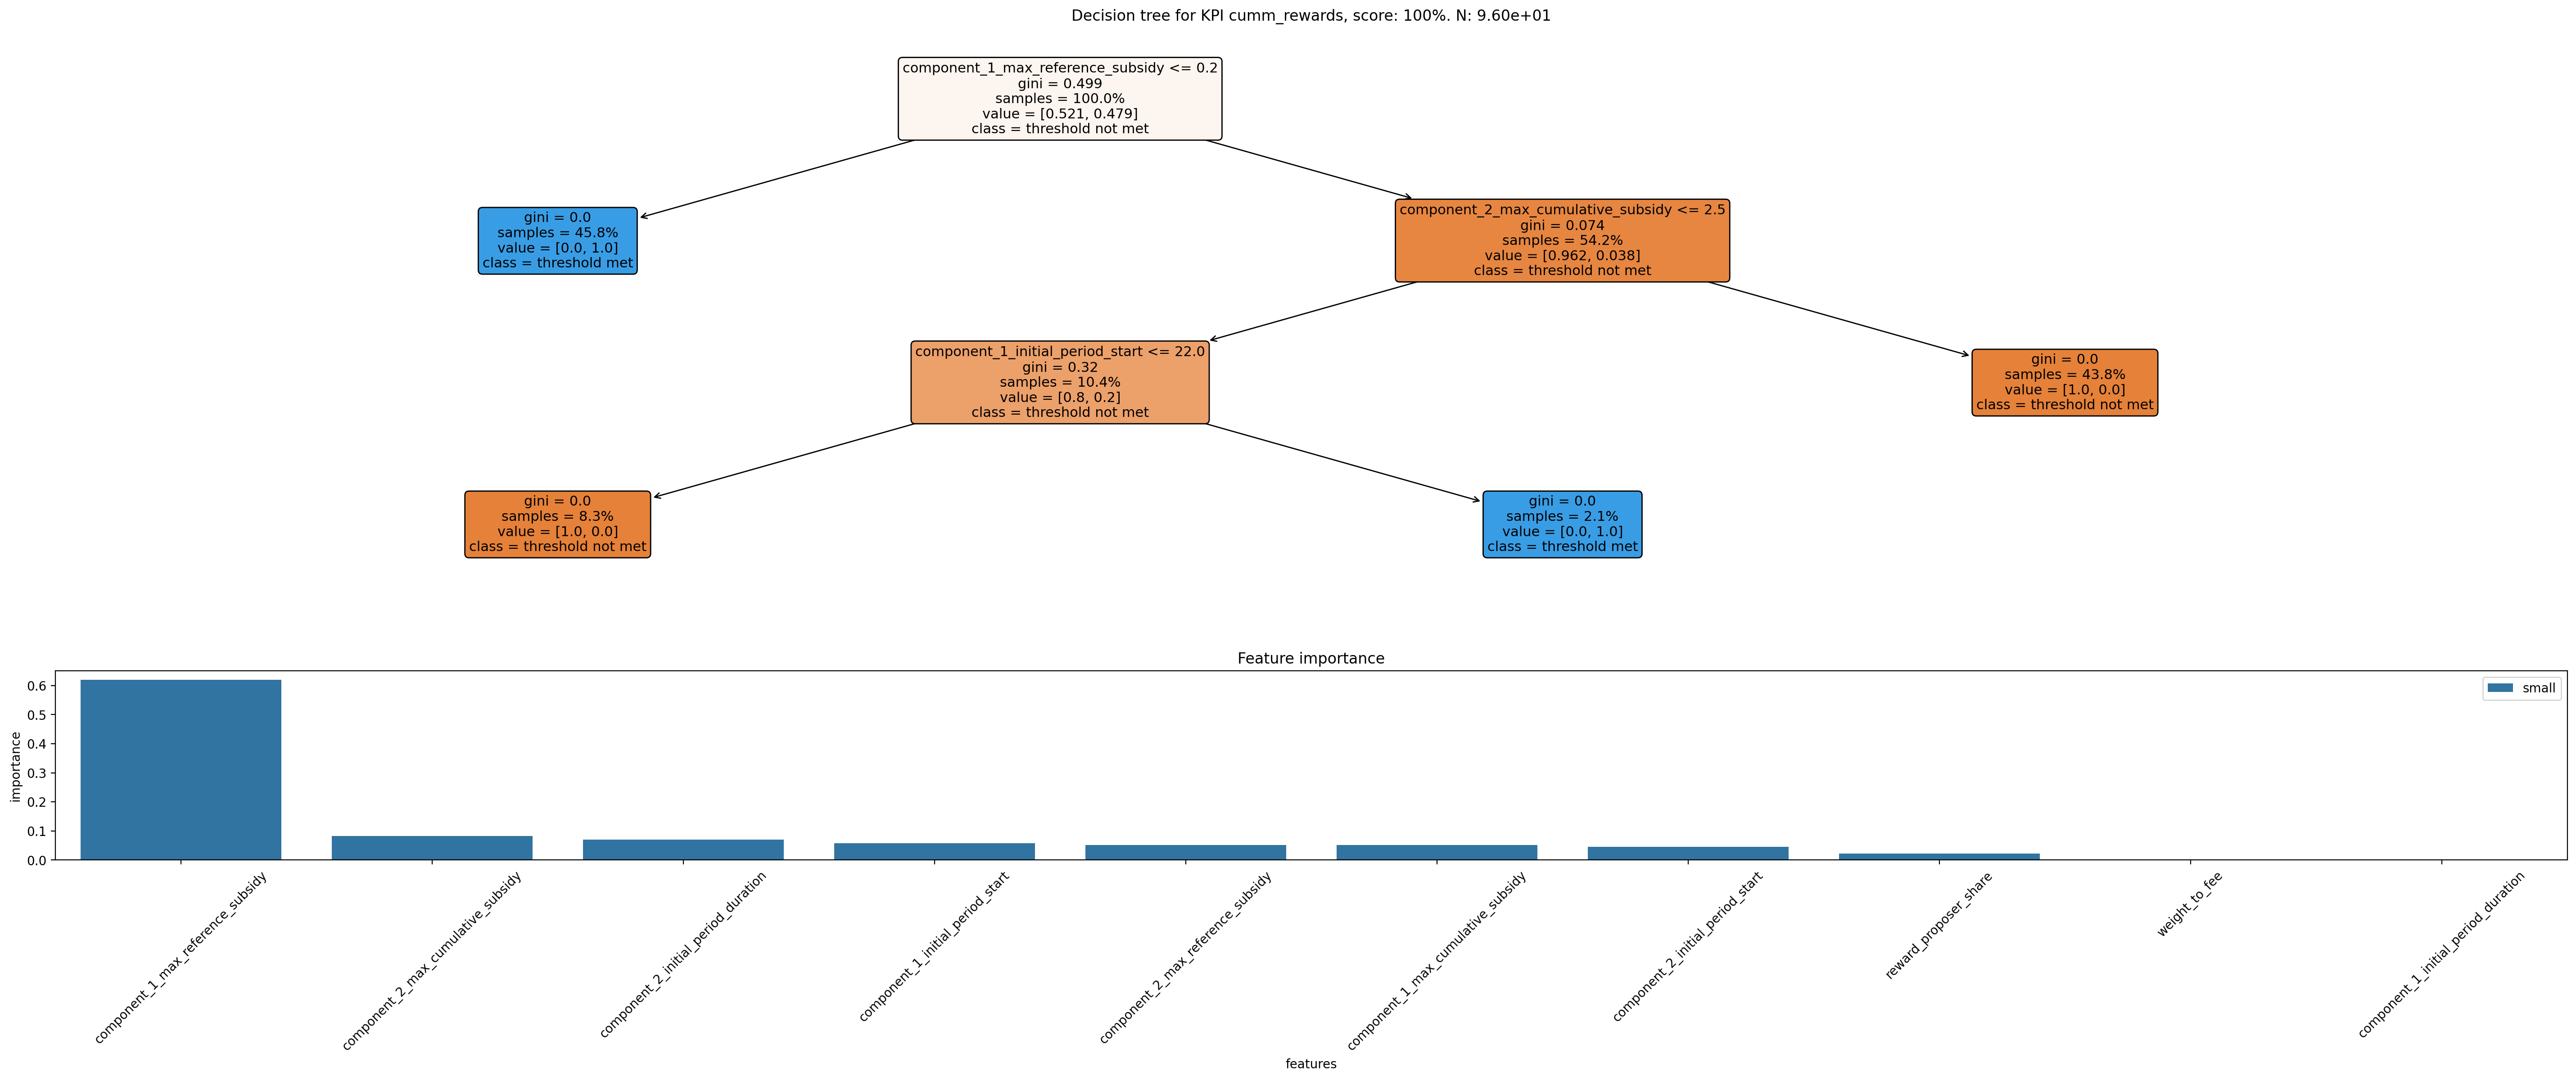

In [18]:
for kpi in KPI_functions.keys():
    try:
        kpi_plot(all_labels_df, kpi)
    except:
        print(f"Error plotting KPI {kpi}")